In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;  
}

<IPython.core.display.Javascript object>

In [2]:
import sys
sys.path.append('/Users/af/Work/code/mcmc/build')
#sys.path.append('/Users/af/Work/code/mcmc/debug')

import mcmc
#help(mcmc)
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [3]:
def gauss_dist(x, mu=0, sigma=1):    
    sigma = np.array(sigma)
    mu = np.array(mu)
    return 1/(np.multiply(sigma,np.sqrt(2*np.pi))) * np.exp(-(x-mu)**2/(2*sigma**2))


def dg(x, alpha=0.5, mu_1=-3, sigma_1=1, mu_2=3, sigma_2=1):
    return alpha*gauss_dist(x, mu_1,sigma_1 )+(1-alpha)*gauss_dist(x, mu_2,sigma_2 )


def dist_andreas(x, alpha=5):
    return np.exp(-(np.cos(-(x-alpha)+(-x+alpha)**2)-1)-0.1*(-x+alpha)**4)/6.90815481092748


def my_sampling(nTrials, xmin, xmax, dist_true, **params):
    
    x = np.linspace(xmin, xmax, 3000)
    max_dist = np.max(dist_true(x, **params))
    
    samplesTrial = xmin+(np.random.rand(nTrials)*(xmax-xmin))
    #only accecpt samples with a random y-coord from [0..something larger than maximum of curve] under the curve
    samples = samplesTrial[ 1.1*max_dist*np.random.rand(nTrials) < dist_true(samplesTrial, **params)]
    
    return samples, samplesTrial


def true_dist(case=0):
    if case==0:# Gaussian w. zero mean and 1 variance
        dist = lambda x: gauss_dist(x, mu=0, sigma=1)
        xmin = -5
        xmax=5
    if case==1: # Double Gaussian 
        dist = lambda x: dg(x, alpha=0.5, mu_1=-3, sigma_1=1, mu_2=3, sigma_2=1)
        xmin = -8
        xmax = 8
    if case==2: # Andreas' dist
        dist = lambda x: dist_andreas(x, alpha=5)
        xmin=1
        xmax=9
    
    return dist, xmin, xmax


def generate_noisy_sample(N=1000, case_dist=0, case_err=0, seed=1234):
    
    """
    N : number of points
    case_dist :  case for distribution of mass (x)
                0 :: gaussian mu=0, sigma=1
                1 :: double gaussian
                2 :: Andreas' dist.

    """
    np.random.seed(seed)   
    
    # Masses
    f, xmin, xmax = true_dist(case_dist)
    x, _ = my_sampling(5*N, xmin, xmax, f)
    Nsamples = x.size
    print('Got %s samples' %Nsamples)
    
    # Redshifts
    z_min=1e-3
    z_max=3
    z = np.linspace(z_min, z_max, Nsamples)
    
    # Errors
    if case_err==0: # quadratic
        sigma = (z/z_max)**2
    if case_err==1: # sqrt
        sigma = (z/z_max)**(1/2)
    
    error = sigma*np.random.normal(size=Nsamples, loc=0, scale=1)
    y = x + error
    
    return y, x, z, sigma, error

In [4]:
y, x, z, sigma, error = generate_noisy_sample(N=5000, case_dist=0, case_err=0)







Got 5662 samples


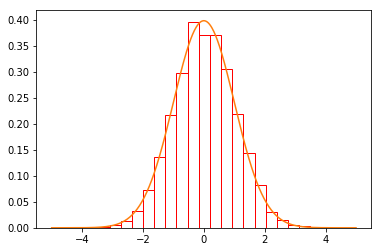

In [5]:
x_1 = np.linspace(-5, 5, 500)
plt.hist(x, 20, density=True, fill=False, edgecolor='red');
plt.plot(x_1, true_dist(case=0)[0](x_1));


In [12]:
#t = mcmc.CoolingTarget(20.0)
t = mcmc.SimpleTarget()
state = mcmc.State()
samples = mcmc.ProbabilityDistributionSamples(y, sigma)

p = mcmc.PiecewiseConstantPDF(samples, -6,6,90)
prior = mcmc.SmoothnessPrior("pdf", 10, -6, 6)
print(p.getNames())

state.add(p)
state.add(prior)

t.set_posterior(state)

c = mcmc.Chain(t, 0)
#c.run(1,0,70,1)

c.run(10000,500,500,1)
#c.run(10,2,2,1)


{'pdf': 0}


In [13]:
print(c.getWeights())
print(c.getLoglikes())

[1. 1. 1. ... 1. 1. 1.]
[-8517.782 -8517.782 -8517.782 ... -8542.167 -8542.167 -8542.167]


(9999, 90)
(90,)


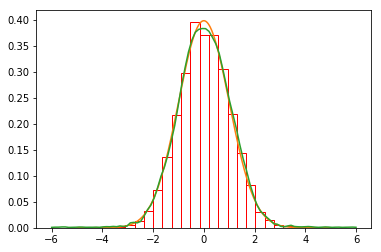

In [14]:
X = c.getSamples("pdf")
print(X.shape)
meanx = np.mean(X, 0)
print(meanx.shape)

x_2 = np.linspace(-6, 6, meanx.shape[0])
plt.hist(x, 20, density=True, fill=False, edgecolor='red');
plt.plot(x_1, true_dist(case=0)[0](x_1));
plt.plot(x_2, meanx)

In [ ]:
X = c.getSamples("position")


weights = c.getWeights()


# Extract x and y
x = X[:, 0]
y = X[:, 1]
# Define the borders
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
print(xmin, xmax, ymin, ymax)
# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

import scipy.stats as st
from sklearn.datasets.samples_generator import make_blobs

positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)



fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(xx, yy, f, cmap='coolwarm')
ax.imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
#cset = ax.contour(xx, yy, f, colors='k')
#ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('2D Gaussian Kernel density estimation')

[0.36787945 0.36787945 0.36787945 ... 0.36787945 0.36787945 0.36787945]


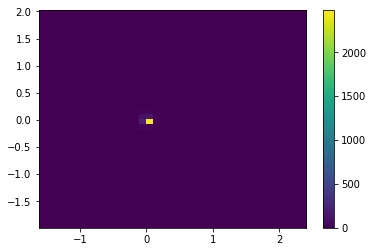

In [45]:
X = c.getSamples("position")


weights = c.getWeights()
print(weights)


# Extract x and y
x = X[:, 0]
y = X[:, 1]

h =plt.hist2d(x, y, 40, weights = weights, cmin = 0)
plt.colorbar(h[3])

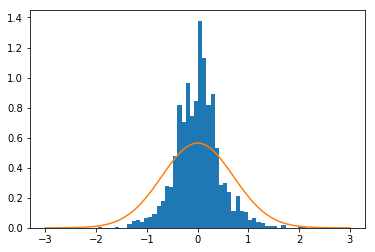

In [29]:
plt.hist(x, bins=50,density=True,weights=weights)
xc = np.linspace(-3,3,100)
plt.plot(xc,np.exp(-(xc**2))/np.sqrt(2*np.pi*0.5))

In [41]:

t = mcmc.SimpleTarget()
t = mcmc.CoolingTarget(20)
L = mcmc.MyLike1()
state = mcmc.State()
state.add(L)

#samples = mcmc.ProbabilityDistributionSamples(y, sigma)
#p = mcmc.PiecewiseConstantPDF(samples, -4,4,40)
#s.add(p)
t.set_posterior(state)

c = mcmc.Chain(t, 0)
#c.run(1,0,70,1)

c.run(0,0,10000,1)



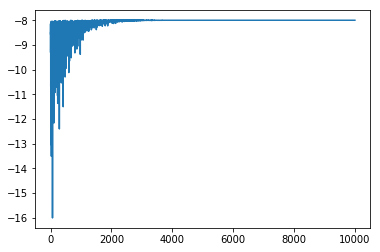

In [42]:
plt.plot(c.getLoglikes())


In [9]:
help(mcmc)

Help on module mcmc:

NAME
    mcmc

CLASSES
    pybind11_builtins.pybind11_object(builtins.object)
        Chain
        ProbabilityDistributionSamples
        SimpleTarget
            CoolingTarget
        State
            MyState
        SubspaceState
            MyLike1
            PiecewiseConstantPDF
    
    class Chain(pybind11_builtins.pybind11_object)
     |  Method resolution order:
     |      Chain
     |      pybind11_builtins.pybind11_object
     |      builtins.object
     |  
     |  Methods defined here:
     |  
     |  __init__(...)
     |      __init__(self: mcmc.Chain, arg0: mcmc.SimpleTarget, arg1: int) -> None
     |  
     |  getLoglikes(...)
     |      getLoglikes(self: mcmc.Chain) -> numpy.ndarray[float32]
     |  
     |  getSamples(...)
     |      getSamples(self: mcmc.Chain, arg0: str) -> numpy.ndarray[float32]
     |  
     |  getWeights(...)
     |      getWeights(self: mcmc.Chain) -> numpy.ndarray[float32]
     |  
     |  run(...)
     |      run(se